# Tully-Fisher Relation of galaxies

For all galaxies in fuji which have valid rotational velocities at $0.33R_{26}$, plot their TFR.  Also include the best-fit TFR (as calibrated using `joint-Coma-0pt_Fuji-TFR_KAD_varyV0-perpdwarf.ipynb`).

In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy import units as u

import numpy as np

import pickle

#import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

# V0 was set as the median value of all the data used in the final calibration

# Data

In [3]:
#tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits') # <-- cori
# tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot.fits')
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.005550764,0.0052407323,0.0054267743,0.0054291883,0.0051505533,0.005328927,0.005367155,0.005074676,0.005267603,0.0053163357,16.432898,0.27237165,3.4572394,5.399334,1.6520585,15.889806,0.2892297,2.7702796,4.85128,0.7334321,15.531683,0.31152296,2.403034,4.429238,0.75814104,0,0.0224279674032048,2.44404472261522e-05,65.28941302448953,11.227243824610715
1548,SGA-2020 1548,SDSSJ1

# TFR

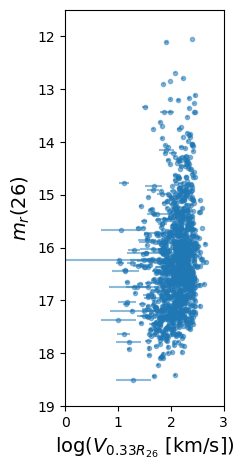

In [4]:
plt.figure(tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.', 
             alpha=0.5)

plt.xlim([0, 3])
plt.ylim([19, 11.5])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$m_r (26)$', fontsize=14)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box');

## Compute the absolute magnitudes based on the redshift

In [5]:
d = c*SGA_TF['Z_DESI']/H0*1e6 # pc
d_err = c*SGA_TF['ZERR_DESI']/H0*1e6 # pc

SGA_TF['R_ABSMAG_SB26'] = SGA_TF['R_MAG_SB26'] - 5*np.log10(d/10.)
SGA_TF['R_ABSMAG_SB26_err'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + (5/np.log(10))**2 * (d_err/d)**2)

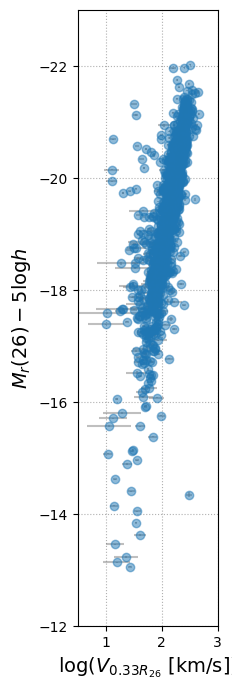

In [6]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_ABSMAG_SB26_err'], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray')

plt.xlim([0.5, 3])
plt.ylim([-12, -23])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$M_r (26) - 5$log$h$', fontsize=14)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box');

## Plotted with our TFR

In [7]:
logv = np.linspace(-1, 3, 100)

### Calibration without dwarfs

Here, $V_0$, the slope, and the y-intercept are from `joint-Coma-0pt-Fuji-TFR_KAD_varyV0-perpdwarfs.ipynb`:

\begin{equation}
  M_r = a (\log(V(0.33R_{26})) - V_0) + b
\end{equation}

where
* $V_0 = 2.02$
* $a = -7.48^{+0.20}_{-0.21} = -7.48\pm 0.21$
* $b = -18.69 \pm 0.12$

*(Updated 7/3/24)*

In [8]:
temp_infile = open('cov_ab_fuji_joint_TFR_varyV0-perpdwarfs2_KAD.pickle', 'rb')
bright_cov_ab, tfr_samples_bright, V0 = pickle.load(temp_infile)
temp_infile.close()

In [9]:
bright_slope = np.median(tfr_samples_bright[0])
bright_slope_err = np.sqrt(bright_cov_ab[0,0])

bright_ZP = np.median(tfr_samples_bright[2])
bright_ZP_err = np.sqrt(bright_cov_ab[2,2])

bright_absmag = bright_slope*(logv - V0) + bright_ZP

In [10]:
# Calculate the uncertainties in the calibrated TFR
bright_slopes = tfr_samples_bright[0]
bright_ZPs = tfr_samples_bright[2]

N_samples = len(bright_slopes)

bright_lines = []

for i in range(N_samples):
    bright_lines.append(bright_slopes[i]*(logv - V0) + bright_ZPs[i])
    
bright_lines_array = np.asarray(bright_lines)
bright_line_err = np.nanpercentile(bright_lines_array, [16 ,84], axis=0)

In [11]:
logV_n17_bright = (-17 - bright_ZP)/bright_slope + V0
b_perp_bright = -17 + (1/bright_slope)*(logV_n17_bright - V0)

dwarf_boolean = (SGA_TF['R_ABSMAG_SB26'] - SGA_TF['R_ABSMAG_SB26_err']) > (-(np.log10(SGA_TF['V_0p33R26']) - V0)/bright_slope + b_perp_bright)

print(10**(logV_n17_bright), 'km/s')

62.253590434712066 km/s


In [12]:
print(sum(dwarf_boolean), 'dwarfs')
print(len(SGA_TF) - sum(dwarf_boolean), 'non-dwarfs')

58 dwarfs
1106 non-dwarfs


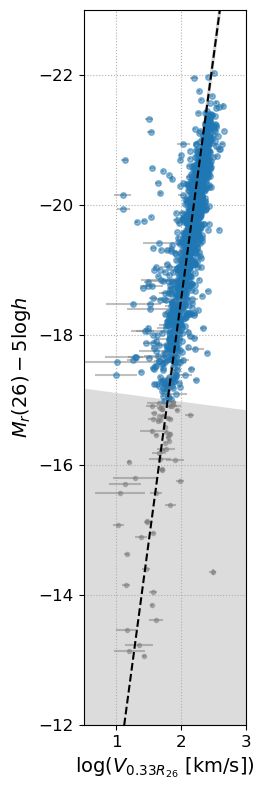

In [31]:
yvals_perp_bright = -(logv - V0)/bright_slope + b_perp_bright

plt.figure(figsize=(4,8), tight_layout=True)

plt.grid(ls=':')

plt.fill_between(logv, bright_line_err[0], bright_line_err[1], color='lightgray')

plt.errorbar(np.log10(SGA_TF['V_0p33R26'][~dwarf_boolean]), 
             SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean], 
             xerr=0.434*SGA_TF['V_0p33R26_err'][~dwarf_boolean]/SGA_TF['V_0p33R26'][~dwarf_boolean],
             yerr=SGA_TF['R_ABSMAG_SB26_err'][~dwarf_boolean], 
             fmt='o', 
             markersize=4, 
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(np.log10(SGA_TF['V_0p33R26'][dwarf_boolean]), 
             SGA_TF['R_ABSMAG_SB26'][dwarf_boolean], 
             xerr=0.434*SGA_TF['V_0p33R26_err'][dwarf_boolean]/SGA_TF['V_0p33R26'][dwarf_boolean],
             yerr=SGA_TF['R_ABSMAG_SB26_err'][dwarf_boolean], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')

plt.plot(logv, bright_absmag, 'k--', zorder=3)

# plt.plot(logv, yvals_perp_bright, 'r:')
plt.fill_between(logv, yvals_perp_bright, -12, color='gainsboro')

plt.xlim([0.5, 3])
plt.ylim([-12, -23])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$M_r (26) - 5$log$h$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_aspect('equal', adjustable='box');

plt.savefig('../../Figures/SV/fuji_jointTFR_varyV0-perpdwarf_20240703.png', dpi=150, facecolor='none');

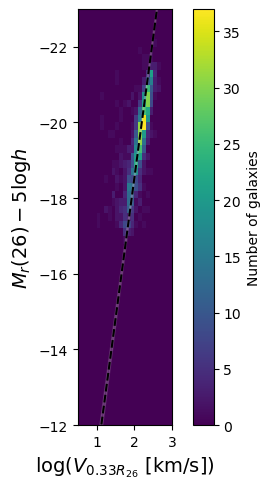

In [28]:
plt.figure(figsize=(4.5,5), tight_layout=True)

plt.hist2d(np.log10(SGA_TF['V_0p33R26'][~dwarf_boolean]), 
           SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean], 
           bins=[np.arange(0.5,3.1,0.1), np.arange(-23, -11.9, 0.2)])
plt.colorbar(label='Number of galaxies')

plt.fill_between(logv, bright_line_err[0], bright_line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, bright_absmag, 'k--', zorder=3)

plt.xlim([0.5, 3])
plt.ylim([-12, -23])

plt.xlabel('log($V_{0.33R_{26}}$ [km/s])', fontsize=14)
plt.ylabel('$M_r (26) - 5$log$h$', fontsize=14);

ax = plt.gca()
ax.set_aspect('equal', adjustable='box');

#### Redshift distribution

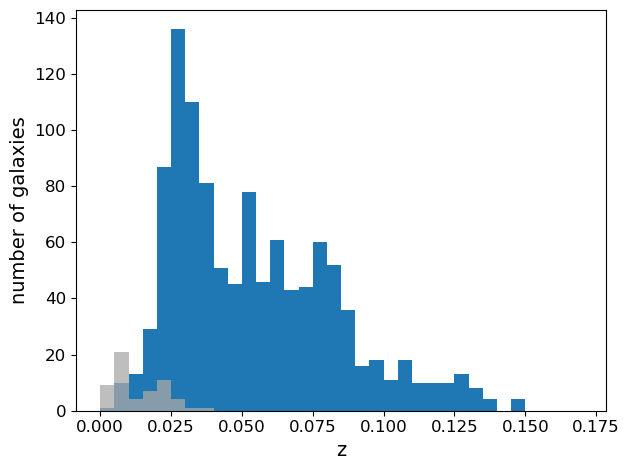

In [15]:
plt.figure(tight_layout=True)

plt.hist(SGA_TF['Z_DESI'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
plt.hist(SGA_TF['Z_DESI'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray', alpha=0.75)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('z', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

# plt.savefig('../../Figures/SV/fuji_z_hist_20240521.png', dpi=150, facecolor='none');

# Compute Peculiar Velocities

In [16]:
SGA_TF['R_ABSMAG_SB26_TFbright'] = bright_slope*(np.log10(SGA_TF['V_0p33R26']) - V0) + bright_ZP

In [17]:
SGA_TF['R_ABSMAG_SB26_TFbright_err'] = np.nan

rng = np.random.default_rng()

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=len(bright_slopes))
    
    Ms = bright_slopes*(np.log10(v_random) - V0) + bright_ZPs
    
    SGA_TF['R_ABSMAG_SB26_TFbright_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_1845774/238348688.py:9: RuntimeWarning: invalid value encountered in log10
  Ms = bright_slopes*(np.log10(v_random) - V0) + bright_ZPs


## Compute distance modulus based on our ITFR

In [18]:
SGA_TF['mu_TFbright'] = SGA_TF['R_MAG_SB26'] - SGA_TF['R_ABSMAG_SB26_TFbright']

SGA_TF['mu_TFbright_err'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + SGA_TF['R_ABSMAG_SB26_TFbright_err']**2)

### $\Delta M_r$ v. redshift

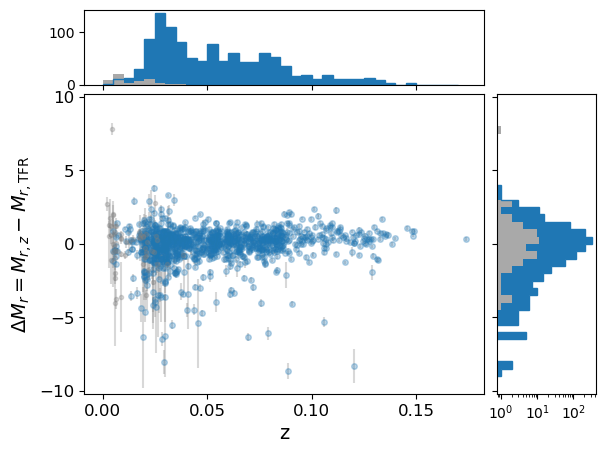

In [36]:
fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax.errorbar(SGA_TF['Z_DESI'][~dwarf_boolean], 
             SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TFbright'][~dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
             yerr=SGA_TF['mu_TFbright_err'][~dwarf_boolean],
             fmt='o', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI'][dwarf_boolean], 
             SGA_TF['R_ABSMAG_SB26'][dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TFbright'][dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
             yerr=SGA_TF['mu_TFbright_err'][dwarf_boolean],
             fmt='.', 
             color='gray',
             alpha=0.3, 
             ecolor='gray')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('z', fontsize=14)
ax.set_ylabel(r'$\Delta M_r = M_{r, z} - M_{r, \text{TFR}}$', fontsize=14)

ax.set_ylim((-10.2, 10.2))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='tab:blue', histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TFbright'][~dwarf_boolean], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TFbright'][dwarf_boolean], 
              bins=np.arange(-12.5, 10, 0.5), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][~dwarf_boolean] - SGA_TF['R_ABSMAG_SB26_TFbright'][~dwarf_boolean], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False);

plt.savefig('../../Figures/SV/fuji_deltaM-v-z_jointTFR-varyV0-perpdwarfs_20240703.png', dpi=150, facecolor='none', bbox_inches='tight');

### Distance modulus v. redshift

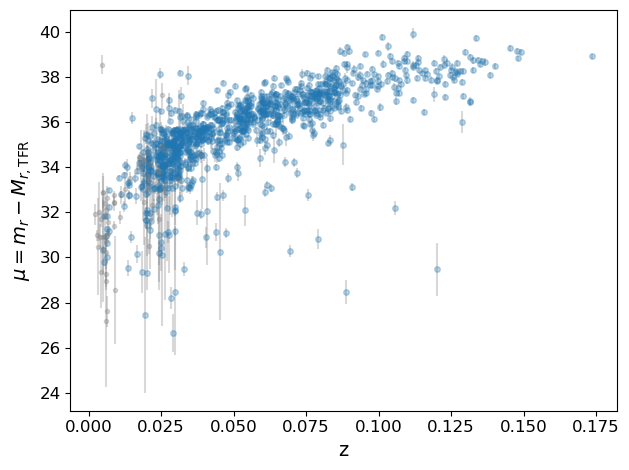

In [20]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_TF['Z_DESI'][~dwarf_boolean], 
             SGA_TF['mu_TFbright'][~dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
             yerr=SGA_TF['mu_TFbright_err'][~dwarf_boolean],
             fmt='o', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')
plt.errorbar(SGA_TF['Z_DESI'][dwarf_boolean], 
             SGA_TF['mu_TFbright'][dwarf_boolean], 
             xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
             yerr=SGA_TF['mu_TFbright_err'][dwarf_boolean],
             fmt='.', 
             color='gray',
             alpha=0.3, 
             ecolor='gray')

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('z', fontsize=14)
plt.ylabel(r'$\mu = m_r - M_{r, \text{TFR}}$', fontsize=14);

### Save distance moduli to a fits file

In [41]:
hdr = fits.Header()

hdr['DESI_DR'] = 'EDR'
hdr['V_RADIUS'] = '0.33 R26'
hdr['M'] = slope
hdr['M_ERR'] = slope_err
hdr['0PT'] = ZP
hdr['0PT_ERR'] = ZP_err
hdr['M_BR'] = bright_slope
hdr['M_ERR_BR'] = bright_slope_err
hdr['V0'] = V0

empty_primary = fits.PrimaryHDU(header=hdr)

In [42]:
table_hdu = fits.BinTableHDU(data=SGA_TF)

hdul = fits.HDUList([empty_primary, table_hdu])

# Write results to file
#SGA_TF.write('SGA_fuji_TFR_moduli.fits', overwrite=True)
hdul.writeto('SGA_fuji_ITFR_moduli.fits', overwrite=True)

In [27]:
## Extract observed redshift and compute peculiar redshift
z_obs = []
dz_obs = []
z_H = []
dz_H = []
z_p = []
dz_p = []
bad_id = []

for i in range(len(sga_tf['SGA_ID'])):
    
    sga_id = sga_tf['SGA_ID'][i]
    M_obs, dM_obs = sga_tf['ABS_MAG_CALC'][i], sga_tf['ABS_MAG_CALC_ERR'][i] 
    M_TF, dM_TF = abs_mag_tf[i], abs_mag_tf_err[i] 
    
    galaxy_list = sga_table[sga_table['SGA_ID'] == sga_id]
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    z_obs.append(zc)
    dz_obs.append(zc_err)
    # print(zc)
    if np.shape(sga_galaxy['R_MAG_SB26']) == (0,):
        bad_id.append(sga_id)
        continue
    m, m_err = float(sga_galaxy['R_MAG_SB26']), float(sga_galaxy['R_MAG_SB26_ERR'])
    zH = zc * 10**((M_obs-M_TF)/5)
    dzH = np.sqrt(zc_err**2 * 10**(2*(M_obs-M_TF)/5) + (zc*np.log(10)/5)**2 * (dM_obs**2 * 10**(2*M_obs/5)+dM_TF**2 * 10**(2*M_TF/5)))
    z_H.append(zH)
    dz_H.append(dzH)
    z_p.append(((1+zc)/(1+zH)) - 1)
    dz_p.append(np.sqrt(((1+zc)/(1+zH)**2 * dzH)**2 + (zc_err/(1+zH))**2))

In [28]:
sga_tf['Z_OBS'] = z_obs
sga_tf['Z_OBS_ERR'] = dz_obs
sga_tf['Z_H'] = z_H
sga_tf['Z_H_ERR'] = dz_H
sga_tf['Z_P'] = z_p
sga_tf['Z_P_ERR'] = dz_p

In [30]:
sga_tf['ABS_MAG_TF'] = abs_mag_tf
sga_tf['ABS_MAG_TF_ERR'] = abs_mag_tf_err

In [31]:
sga_tf.write('cache/SGA_PV.fits', format = 'fits', overwrite = True)

In [12]:
sga_tf = Table.read('cache/SGA_PV.fits', format = 'fits')
sga_tf.columns

<TableColumns names=('SGA_ID','PGC','RMAG','RMAG_ERR','VMAX','VMAX_ERR','LOG_VMAX','LOG_VMAX_ERR','ABS_MAG_CALC','ABS_MAG_CALC_ERR','Z_OBS','Z_OBS_ERR','Z_H','Z_H_ERR','Z_P','Z_P_ERR','ABS_MAG_TF','ABS_MAG_TF_ERR')>

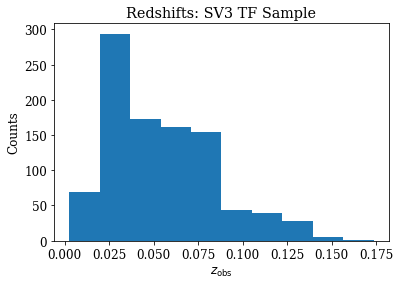

In [20]:
plt.hist(sga_tf['Z_OBS'])
plt.xlabel(r'$z_\mathrm{obs}$')
plt.ylabel('Counts')
plt.title('Redshifts: SV3 TF Sample')
# plt.axvline(0.05, color = 'k', ls = ':')
# plt.show()
plt.savefig('z_obs_hist_SV3.png', dpi=120, transparent=True)